# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Optimalizace hejnem částic je optimalizační algoritmus inspirovaný chováním hejn ryb nebo ptáků při hledání potravy, který se používá pro spojitou optimalizaci. Jedinec, typicky vektor R čísel, se nazývá částice a pohybuje se v hejnu prostorem parametrů. Každá částice je reprezentovaná pomocí 2 vektorů, které určují její pozici a rychlost. Navíc si pamatuje pozici v prostoru, kde měla nejlepší fitness a celé hejno si pamatuje pozici, kde měla nějaká částice nejlepší globální fitness. 

Algoritmus je pak velice jednoduchý -- každá částice se pohybuje v prostoru a je přitahovaná k místu se svým nejlepším řešením a k místu globálního nejlepšího řešení. Na začátku se inicializuje každé částici pozice a rychlost náhodně. Pak se pro každou částici spočítá její fitness, updatuje se dosavadní nejlepší pozice jedince a globální nejlepší pozice v hejnu. Nakonec se spočítá nová rychlost a pozice jedince z původní pozice a rychlosti, jejího nejlepšího místa a globálního nejlepšího místa v hejnu. Toto se opakuje dokud není splněno nějaké ukončovací kritérium, například počet iterací.


Zkusíme se tedy podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. 

In [3]:
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

Dále budeme potřebovat funkci na aktualizaci pozic a rychlostí všech částic v hejnu podle rovnic.

In [4]:
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*(particle.best_position - particle.position) + phi2*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position
    return swarm

Také bude potřeba funkce na update nejlepšího globálního řešení. K tomu si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě.

In [5]:
def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

# fitness funkce
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 

Nyní už máme všechny funkce, takže si už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [6]:
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

   0: 3.5051
   1: 2.3426
   2: 2.0357
   3: 2.0181
   4: 2.0181
   5: 2.0181
   6: 2.0181
   7: 2.0181
   8: 2.0181
   9: 1.9959
  10: 1.9959
  11: 1.9959
  12: 1.9959
  13: 1.9959
  14: 1.9959
  15: 1.9959
  16: 1.9913
  17: 1.9913
  18: 1.9913
  19: 1.9913
  20: 1.9913
  21: 1.9913
  22: 1.9913
  23: 1.9901
  24: 1.9901
  25: 1.9901
  26: 1.9901
  27: 1.9901
  28: 1.9901
  29: 1.9901
best position
[[9.95534864e-01 6.80038738e-05 7.44769553e-04 9.94742091e-01]]


Text(0.5, 0, 'Generace')

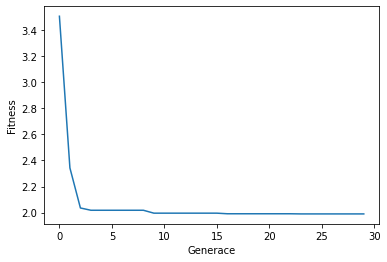

In [7]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=4, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) je algoritmus inspirovaný chováním mravenců při hledání potravy, který se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na problém hledání cest v grafu. 

Mravenci se pohybují v prostředí a zanechávají za sebou feromonouvou stopu, která časem slábne a díky které spolu komunikují a slouží jim jako pozitivní druh zpětné vazby. Mravenec začne v náhodném bodě a rozhoduje se kam půjde dál. Nejprve se pohybují náhodně kolem mraveniště. Jakmile naleznou potravu, vrací se stejnou cestou, kterou k potravě došli a zanechávají za sebou feromonovou stopu. Jakmile nějkaý další mravenec narazí na feromonovou stopu, s větší pravděpodobností se po ní vydá spíše, než aby dále prozkoumával prostředí. Čím více mravenců se pohybuje mezi zdrojem potravy a mraveništěm, tím silnější je stopa a šance, že cesta přitáhne další mravence. Navíc na kratší cestě feromon vyprchává pomaleji, takže bude silnější a bude přitahovat více mravenců.

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).

Zkusíme si s jeho pomocí vyřešit [Problém obchodního cestujícího](https://en.wikipedia.org/wiki/Travelling_salesman_problem), který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Hamiltonovská kružnice v grafu je kružnice, která prochází všemi vrcholy. Implementace už je zde trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. 

In [8]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat.

In [9]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [10]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

In [11]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení, a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [12]:
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution


Nyní už si můžeme vytvořit hlavní kód ACO.

In [13]:
def ant_solver(vertices, distance, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [14]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

best_solution, pheromones = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

 169, 246.2179, 261.4670, 280.9602
 170, 246.2179, 275.9602, 307.2036
 171, 246.2179, 288.4011, 373.5913
 172, 246.2179, 266.8524, 292.8906
 173, 248.8089, 292.5180, 341.9726
 174, 246.2179, 283.1322, 346.0627
 175, 246.2179, 302.0065, 359.9349
 176, 253.6836, 287.9587, 334.5726
 177, 258.5385, 281.7133, 325.1573
 178, 259.7030, 277.7662, 301.3849
 179, 246.2179, 301.4708, 373.1128
 180, 255.7505, 283.7588, 316.4729
 181, 250.3096, 275.7617, 309.0753
 182, 246.2179, 274.5076, 307.3300
 183, 251.5144, 277.5139, 327.2949
 184, 252.9426, 291.6564, 345.4962
 185, 246.2179, 271.3463, 338.1869
 186, 246.2179, 260.5907, 278.0360
 187, 263.6279, 279.8071, 307.5844
 188, 257.4194, 288.9155, 329.9621
 189, 265.4326, 291.5855, 331.2068
 190, 251.2664, 285.1644, 338.9222
 191, 257.8621, 295.0834, 337.4839
 192, 260.7881, 289.2715, 339.5458
 193, 257.5356, 290.3879, 357.9387
 194, 265.1937, 292.9675, 361.1684
 195, 255.3537, 299.3556, 341.2093
 196, 255.3537, 298.3712, 330.7699
 197, 273.9001, 294.

 405, 273.6081, 304.1747, 335.0184
 406, 286.1215, 299.9948, 338.5983
 407, 280.2743, 295.3855, 315.2337
 408, 290.6619, 308.3891, 374.2064
 409, 281.2457, 300.8372, 331.7881
 410, 279.6469, 303.0840, 323.8245
 411, 290.4629, 305.4103, 336.7544
 412, 270.0847, 297.0087, 332.4117
 413, 270.0847, 293.1164, 332.5558
 414, 261.0016, 294.5980, 338.3917
 415, 272.7857, 296.9391, 317.5483
 416, 272.1278, 299.2424, 342.9016
 417, 274.6559, 299.5309, 345.5033
 418, 266.4273, 299.3810, 337.5497
 419, 261.0016, 289.6927, 315.8359
 420, 261.0016, 279.7506, 295.3097
 421, 265.2806, 297.5095, 332.8753
 422, 272.5897, 292.3508, 366.1681
 423, 277.1547, 296.9881, 325.7886
 424, 270.3733, 296.2817, 333.9527
 425, 270.3733, 292.1034, 331.8229
 426, 270.3733, 297.5767, 318.1140
 427, 275.3586, 288.9935, 309.7006
 428, 276.1409, 290.1689, 319.3636
 429, 264.5060, 292.0102, 331.7302
 430, 271.0554, 290.8694, 326.5664
 431, 262.9691, 280.7366, 311.9754
 432, 253.7375, 299.3369, 336.1478
 433, 273.8854, 302.

 644, 276.5262, 298.4882, 332.2623
 645, 266.0266, 285.9771, 324.3365
 646, 263.1219, 288.3903, 312.3107
 647, 266.0266, 290.2270, 344.8389
 648, 266.0266, 291.8655, 317.6424
 649, 252.2040, 275.4063, 317.5134
 650, 250.9872, 276.6491, 330.9960
 651, 263.4734, 281.4235, 310.2404
 652, 269.4302, 289.2299, 320.4769
 653, 266.8583, 293.5110, 323.3826
 654, 266.6701, 283.4626, 319.2005
 655, 266.6701, 288.4998, 305.4986
 656, 239.6183, 278.9431, 322.7510
 657, 265.9466, 287.3821, 326.6663
 658, 266.1859, 288.1142, 319.0731
 659, 255.1872, 299.7442, 317.3863
 660, 267.6938, 300.8531, 330.2483
 661, 272.6364, 296.6889, 318.9635
 662, 263.4951, 281.5229, 328.1794
 663, 265.9466, 287.5972, 336.8639
 664, 259.2122, 286.5716, 312.9697
 665, 255.4930, 287.2047, 344.2927
 666, 265.9466, 296.5810, 339.1516
 667, 263.2138, 282.3676, 305.8213
 668, 258.3801, 280.7778, 294.0696
 669, 267.4458, 298.2831, 338.5489
 670, 267.1931, 290.5810, 321.2131
 671, 252.2040, 283.0810, 333.3982
 672, 252.9126, 278.

 881, 264.5060, 294.2112, 325.0200
 882, 265.6174, 298.1315, 336.8054
 883, 266.8082, 293.1417, 330.2868
 884, 263.1219, 295.0195, 328.0814
 885, 276.2200, 297.9246, 339.1959
 886, 262.5820, 285.8787, 313.1008
 887, 262.5820, 290.7055, 332.7590
 888, 270.0847, 295.4954, 334.3860
 889, 265.8637, 285.9816, 338.8782
 890, 258.4683, 279.8131, 290.5872
 891, 261.4556, 279.1998, 290.7648
 892, 244.1767, 285.9584, 331.3577
 893, 258.9760, 272.3336, 292.3256
 894, 267.1537, 288.6582, 333.6738
 895, 266.5178, 279.6729, 297.1931
 896, 265.2806, 280.2167, 291.5591
 897, 266.5178, 281.1736, 292.7291
 898, 271.2975, 284.4718, 308.3443
 899, 267.6832, 279.0855, 310.5598
 900, 266.9093, 284.6068, 337.9937
 901, 264.2262, 276.0981, 288.2358
 902, 260.1933, 280.6316, 316.4587
 903, 255.7812, 273.2726, 290.9008
 904, 264.5060, 281.8050, 296.6841
 905, 253.9947, 274.8367, 312.5429
 906, 254.8124, 280.0339, 298.5313
 907, 259.1232, 280.6335, 306.8879
 908, 256.5615, 279.5257, 353.3696
 909, 255.1806, 281.

1119, 258.7496, 296.3272, 351.0700
1120, 270.0094, 297.4217, 353.8415
1121, 267.5347, 295.5154, 322.1915
1122, 269.7771, 297.9386, 333.6946
1123, 267.5821, 293.2461, 315.2792
1124, 272.5832, 293.3088, 310.0191
1125, 272.5832, 311.4783, 350.7430
1126, 250.9770, 299.0486, 364.2672
1127, 275.5608, 307.2802, 339.7317
1128, 292.8684, 303.9842, 320.5880
1129, 234.8760, 292.3398, 326.4920
1130, 269.6478, 292.0097, 313.2886
1131, 292.6209, 302.8119, 318.6231
1132, 288.2562, 308.0699, 353.5728
1133, 275.9227, 311.6544, 355.1960
1134, 284.8121, 295.2060, 314.1788
1135, 281.8030, 306.9690, 335.1961
1136, 276.9620, 300.9562, 326.3120
1137, 286.0019, 310.6271, 340.8755
1138, 272.7621, 295.7236, 329.1215
1139, 256.1638, 310.2685, 350.3680
1140, 291.4214, 325.0500, 356.0772
1141, 285.8346, 312.6455, 356.0772
1142, 267.0194, 315.2668, 432.1336
1143, 249.3946, 297.5454, 349.6469
1144, 248.2600, 295.7788, 332.7691
1145, 260.8858, 290.7699, 322.8957
1146, 254.8249, 301.3399, 367.4678
1147, 264.2043, 294.

1354, 267.7888, 282.2699, 307.8997
1355, 282.8472, 301.9390, 335.5658
1356, 256.8224, 283.8590, 306.2286
1357, 256.7483, 284.7214, 315.1141
1358, 270.3615, 294.6260, 327.8859
1359, 287.3023, 310.0354, 369.3196
1360, 279.3552, 311.2938, 346.2262
1361, 265.7056, 299.0021, 348.0925
1362, 265.7056, 296.8247, 322.6143
1363, 259.3128, 300.5601, 338.3709
1364, 266.1380, 296.9794, 331.5770
1365, 283.2119, 305.4925, 341.3631
1366, 257.8655, 296.2619, 327.0519
1367, 258.5997, 301.0187, 328.2437
1368, 278.8342, 298.6261, 324.5276
1369, 278.3826, 298.6590, 326.6040
1370, 279.2206, 299.7278, 325.1534
1371, 276.7428, 293.2053, 309.0477
1372, 280.9544, 306.4379, 355.4422
1373, 275.9235, 306.7762, 338.2755
1374, 276.8263, 299.3426, 319.9924
1375, 275.4930, 293.7806, 328.7510
1376, 277.5995, 300.3698, 355.2997
1377, 265.8822, 298.3881, 339.4846
1378, 273.7318, 302.2633, 343.8846
1379, 271.8646, 299.2843, 328.8098
1380, 267.9221, 291.3818, 342.0083
1381, 280.3658, 299.4613, 332.5017
1382, 267.9221, 302.

1591, 270.5376, 301.1985, 317.0045
1592, 266.0855, 305.5515, 327.5375
1593, 262.6469, 298.9242, 363.0830
1594, 262.6469, 285.5400, 329.9286
1595, 262.6703, 294.0709, 354.1770
1596, 262.6469, 295.1046, 351.5180
1597, 272.9877, 313.0298, 336.5184
1598, 267.1038, 287.8064, 317.7217
1599, 255.0135, 281.5638, 320.2201
1600, 255.0135, 286.4312, 358.0960
1601, 261.0702, 292.3457, 321.1053
1602, 291.6665, 306.1888, 331.6994
1603, 275.4342, 296.0524, 331.4155
1604, 278.5337, 305.1418, 344.3535
1605, 289.9286, 317.7115, 356.3594
1606, 269.9785, 309.6113, 365.4792
1607, 282.3977, 306.0701, 321.9459
1608, 279.9248, 304.1190, 351.4011
1609, 252.8341, 291.0794, 321.6056
1610, 259.4923, 295.6751, 333.4272
1611, 259.4923, 295.0700, 358.7194
1612, 259.4923, 293.8758, 327.2099
1613, 266.7871, 291.5720, 322.0547
1614, 270.2011, 292.3799, 327.9437
1615, 282.1778, 306.7719, 351.1727
1616, 274.5220, 300.2745, 352.6876
1617, 275.2824, 290.7346, 310.4201
1618, 271.4423, 296.4665, 317.7687
1619, 253.2009, 300.

1828, 269.3396, 295.7759, 343.4683
1829, 269.8730, 294.5228, 317.5004
1830, 268.1632, 296.7533, 320.6030
1831, 253.2636, 296.8481, 332.0260
1832, 273.8724, 292.5114, 342.9728
1833, 276.0929, 301.2789, 328.1264
1834, 279.7813, 301.8754, 326.9960
1835, 277.5498, 298.1063, 326.8623
1836, 273.6748, 297.9210, 326.1549
1837, 275.8635, 299.5033, 328.3443
1838, 277.3815, 292.8152, 311.2649
1839, 260.0583, 293.8749, 337.2389
1840, 277.9663, 300.2538, 325.4733
1841, 276.8569, 303.3982, 337.5590
1842, 277.3950, 296.4926, 328.6372
1843, 275.9084, 300.7795, 320.9196
1844, 282.9155, 301.6272, 322.3878
1845, 283.1205, 305.5193, 318.0056
1846, 275.6005, 290.2057, 313.2020
1847, 277.3950, 300.6165, 320.1507
1848, 270.0144, 296.8243, 323.5310
1849, 278.9750, 295.0825, 323.8176
1850, 264.7593, 288.6783, 338.5379
1851, 263.0694, 282.6976, 307.9685
1852, 278.8272, 310.8477, 344.8750
1853, 266.7092, 304.6826, 331.0145
1854, 276.9888, 301.9116, 332.7259
1855, 262.8575, 298.0247, 340.9262
1856, 248.9539, 303.

2065, 264.0872, 295.6917, 328.2164
2066, 248.5150, 286.7048, 335.2238
2067, 258.2266, 274.4391, 312.6591
2068, 263.0287, 282.8290, 316.7170
2069, 253.6047, 273.4085, 292.8968
2070, 241.3759, 290.4386, 333.6793
2071, 253.6047, 292.5781, 346.3788
2072, 253.6047, 284.6332, 338.7611
2073, 253.1439, 287.0106, 318.8562
2074, 270.9456, 283.6644, 304.2057
2075, 260.1143, 281.6820, 294.9906
2076, 259.3979, 287.6194, 338.7804
2077, 259.3979, 296.9609, 327.8410
2078, 249.3636, 280.6961, 316.8963
2079, 269.1431, 286.3435, 323.4330
2080, 260.3857, 287.9847, 308.7049
2081, 264.0368, 279.6552, 309.0149
2082, 257.3629, 282.0627, 317.2787
2083, 255.0240, 287.9528, 323.0769
2084, 247.5318, 292.8786, 331.8626
2085, 255.0240, 296.9792, 332.5338
2086, 269.3672, 296.4747, 357.7885
2087, 247.5318, 290.9161, 350.8590
2088, 249.9928, 282.0292, 302.3492
2089, 260.1683, 280.3431, 313.4359
2090, 266.7721, 282.8851, 309.9556
2091, 255.7294, 286.4060, 319.1561
2092, 261.4668, 295.2815, 345.1070
2093, 265.1438, 280.

2300, 272.1530, 289.1112, 317.4760
2301, 261.4519, 287.5111, 317.1842
2302, 271.0908, 304.9939, 388.0168
2303, 269.3278, 286.6974, 330.4286
2304, 268.0564, 300.7380, 352.7662
2305, 278.0019, 310.4161, 362.4292
2306, 268.0564, 306.5718, 350.2688
2307, 273.9776, 314.9708, 340.1481
2308, 255.9314, 299.1673, 329.6903
2309, 264.4578, 290.8153, 326.5172
2310, 250.3570, 291.9247, 340.0005
2311, 247.0128, 282.9059, 325.5629
2312, 247.5318, 288.8216, 334.3232
2313, 267.9642, 294.0448, 328.0963
2314, 268.4321, 300.7685, 323.9827
2315, 266.1660, 297.8611, 327.1598
2316, 260.4183, 295.5833, 338.5604
2317, 255.7185, 287.4347, 332.7779
2318, 252.2509, 286.1355, 378.0318
2319, 262.6117, 297.7458, 348.3843
2320, 258.4903, 311.5361, 395.2437
2321, 261.1194, 307.6247, 384.7394
2322, 258.1539, 305.7135, 350.1055
2323, 244.2026, 292.0528, 352.5374
2324, 246.3330, 313.0175, 346.6703
2325, 244.4274, 306.4013, 341.8446
2326, 246.3330, 307.1372, 418.6043
2327, 238.5551, 281.7573, 325.9197
2328, 260.3337, 295.

2534, 274.2443, 306.6677, 357.8095
2535, 261.9502, 296.9526, 326.5178
2536, 262.7736, 305.5153, 331.2491
2537, 274.6684, 305.5097, 355.0147
2538, 269.7951, 304.3472, 361.4497
2539, 261.3336, 291.7410, 340.0060
2540, 270.5876, 307.2226, 339.7971
2541, 280.7398, 308.5373, 367.4208
2542, 265.5182, 306.2457, 367.4208
2543, 267.1839, 300.2428, 360.1656
2544, 261.4961, 308.9108, 350.3862
2545, 264.6063, 289.6391, 321.2068
2546, 270.9458, 293.3446, 315.8508
2547, 261.5106, 291.9494, 329.2802
2548, 268.4980, 298.7022, 330.0516
2549, 254.8575, 301.8805, 352.0039
2550, 263.3193, 304.4726, 330.1594
2551, 263.3193, 309.7272, 357.7744
2552, 266.6812, 299.5756, 359.4890
2553, 262.4411, 308.0247, 365.7920
2554, 266.6812, 300.4778, 360.6672
2555, 261.8532, 304.3341, 345.7133
2556, 264.8211, 300.6636, 341.6684
2557, 271.7227, 304.6348, 345.1055
2558, 277.1969, 299.6633, 340.9053
2559, 255.9296, 303.8311, 358.7938
2560, 268.4980, 284.0309, 320.9573
2561, 278.7561, 298.8916, 344.8897
2562, 264.3140, 285.

2769, 273.5573, 297.4750, 324.4644
2770, 283.9910, 326.1054, 362.9886
2771, 288.4150, 302.0825, 343.6273
2772, 257.3093, 292.9571, 304.6304
2773, 282.1917, 306.9094, 340.6593
2774, 276.0703, 296.8728, 314.8613
2775, 265.4125, 294.5759, 319.3504
2776, 283.2440, 302.0453, 318.8387
2777, 262.8569, 293.2335, 308.2339
2778, 273.9776, 288.0596, 297.5943
2779, 255.4496, 291.5214, 312.9750
2780, 276.0424, 295.6719, 360.0437
2781, 271.6768, 290.9838, 329.9957
2782, 266.4701, 295.5971, 334.9421
2783, 266.4701, 295.9443, 313.0135
2784, 279.8952, 302.9665, 352.3028
2785, 276.0191, 301.4697, 330.4112
2786, 273.9188, 296.5499, 313.7206
2787, 269.3678, 291.1827, 315.2799
2788, 273.9776, 289.7463, 301.5899
2789, 272.6126, 293.8226, 309.9730
2790, 280.5672, 300.4281, 342.1766
2791, 270.9140, 306.0390, 344.3198
2792, 283.3844, 296.0215, 321.1423
2793, 288.4354, 304.1119, 324.5888
2794, 273.9776, 291.0308, 327.7036
2795, 273.9776, 296.6781, 325.4520
2796, 269.3043, 294.0077, 324.5789
2797, 261.2677, 298.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Červenou barvou vykreslíme nejlepší řešení a vypíšeme si i jeho fitness a pořadí měst v něm. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení. 

Fitness:  232.17340606711963
[Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Valletta', x=14.51666667, y=35.9),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Skopje', x=21.46666667, y=42.0),
 Vertex(name='Pristina', x=21.16666667, y=42.65),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Bucharest', x=26.1, y=44.43333333),
 Vertex(name='Chisinau', x=28.81666667, y=47.01666667),
 Vertex(name='Kyiv', x=30.51666667, y=50.41666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Vilnius', x=25.26666667, y=54.7),
 Vertex(name='Riga', x=24.11666667, y=56.96666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Stockholm', 

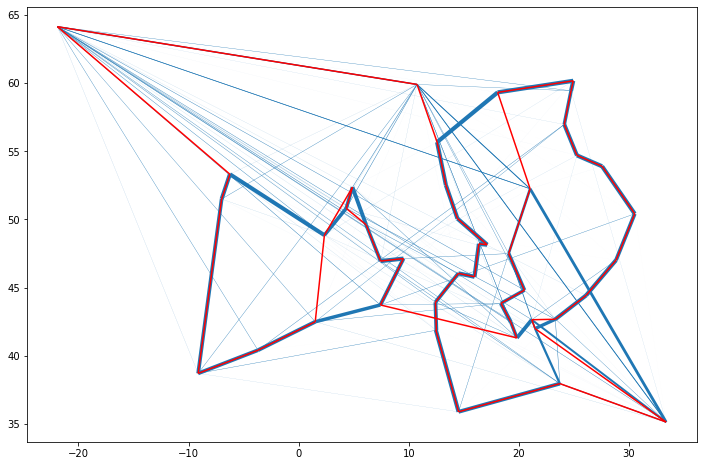

In [15]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))

solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

Pěkná simulace hledání nejkratší cesty v grafu se nachází [zde](http://thiagodnf.github.io/aco-simulator).

## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Umělé včelí kolonie (ABC) je optimalizační algoritmus založený na chování včel při hledání potravy. Včely jsou rozděleny do třech skupin - na dělnice, vyčkávající včely a průzkumníky. Každá dělnice opracovává jeden zdroj jídla (a pozice těchto zdrojů kódují řešení). Při opracování dělnice navštíví zdroje jídla v okolí, a pokud je jiné řešení kvalitnější (má lepší fitness) nahradí svůj zdroj tímto novým zdrojem. Potom se všechny dělnice sejdou v úle, vymění si informace o kvalitě zdrojů a vyčkávající včely si vyberou některé z těchto zdrojů pomocí ruletové selekce. Dělnice si zároveň pamatují, jak dlouho už opracovávají daný zdroj, a pokud přesáhne tato doba nastavený limit, zdroj opustí a stanou se z nich průzkumníci. Průzkumníci prohledávají prostor náhodně a hledají nové zdroje potravy

Zkuste si tedy naimplementovat ve zbytku cvičení optimalizaci pomocí včelí kolonie a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic.

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline.